In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import FormatStrFormatter

# import seaborn as sns

In [3]:
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (16, 4), # 2.2*len(csvs)
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'xtick.major.size': 7.0,
    'ytick.major.size': 3.0,
    'pdf.fonttype': 42
}
pylab.rcParams.update(params)

In [102]:
def plot_csv(
    ax, csv_file, configs, Ds, D_labels,
    error_field='rel_frob_error',
    regression=False, y_lim=None,
    logscale=False, title='dataset',
    x_axis=True, ylabel='',
    ylog=False
):
    
    bar_positions = []
    data_names = []
    
    d_in = int(csv_file.split('_')[-2][1:])
        
    df = pd.read_csv(csv_file)
    
    df['feature_train_ratio'] = df['feature_time'] / df['pred_time']
#     df = df[(df['D'] > 1024) & (df['D'] % 2048 == 0)]
#     df = df[(df['D'] % (d_in*2) == 0)]
#     df = df[(df['D'].isin([1024, 2*1024, 3*1024, 4*1024, 5*1024]))]
    # Ds = np.sort(df['D'].unique())
    df = df[df['D'].isin(Ds)]
    seeds = df['seed'].unique()

    bar_positions = np.arange(len(Ds))
    width = 1./(len(configs)+1)
    
    cluster_mean = 0
    
    # we need to pre-filter the dataframe so that we only accept complete seeds given D
    # for D in Ds:
    #     for seed in seeds:
    #         sel = df[(df['seed'] == seed) & (df['D'] == D)]
    #         if len(sel) < len(configs):
    #             # seed is incomplete
    #             df.drop(df.index[(df['seed'] == seed) & (df['D'] == D)], inplace = True)
    
    for j, (name, config) in enumerate(configs):
        
        df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
        df_sel = df_sel[(df_sel['comp'] == config['complex'])]
        df_sel = df_sel[(df_sel['ahle'] == config['ahle'])]
        # df_sel = df_sel[(df_sel['seed'] < 10)]
        
        dataset = df_sel['dataset'].iloc[0]
        
        df_sel = df_sel.groupby(['D'])

        error_means = df_sel[error_field].mean()
        error_stds = df_sel[error_field].std()
        error_max = df_sel[error_field].max()
        error_min = df_sel[error_field].min()
        error_median = df_sel[error_field].median()
        
#         if dataset == 'cifar10_conv':
#             print(config)
#             print('Mean', error_means)
#             print('Std', error_stds)
#             print('Max', error_max)
#             print('Min', error_min)
#             print('Median', error_median)
        
        ax.bar(
            bar_positions + j*width, error_means,
            yerr=error_stds,
            error_kw=dict(lw=1, capsize=1, capthick=1, alpha=0.3),
            color=config['color'],
            width=width,
            label=name,
            align='edge'
        )
    ax.set_xticks(
        bar_positions+len(configs)*width/2.,
        labels=D_labels
    )
    if not x_axis:
#         ax.set_xticks([])
        ax.set_xticklabels([])

#     if error_field == 'test_kl':
#         ax.yaxis.set_major_formatter(FormatStrFormatter("%.0e"))

    if logscale:
        ax.set_yscale('log')

    if ylabel != '':
        ax.set_ylabel(ylabel)
        
    if y_lim is not None:
        ax.set_ylim(y_lim)
        
    if ylog:
        ax.set_yscale('log')
        
#     ax.set_xlabel('Feature Map Dimension ' + r'$D$')
    ax.set_title(title)

#     ax.legend() # loc='upper center', ncol=8

In [114]:
colors = plt.get_cmap('tab20c')(np.linspace(0, 0.8, 17))[::2]
colors = np.flip(colors, axis=0)

In [117]:
configs = [
    ('Gaussian', {'method': 'poly_sketch', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[0]}),
    ('Complex Gaussian', {'method': 'poly_sketch', 'proj': 'gaussian', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[1]}),
    ('Rademacher', {'method': 'poly_sketch', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[2]}),
    ('Complex Rademacher', {'method': 'poly_sketch', 'proj': 'rademacher', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[3]}),
    ('TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[4]}),
    ('Complex TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[5]}),
    ('Opt. Maclaurin TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[4]}),
    ('Opt. Complex Maclaurin TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[5]}),
    ('Ahle et al. TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'ahle': True, 'comp_real': False, 'color': colors[6]}),
    ('Complex Ahle et al. TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': True, 'comp_real': False, 'color': colors[7]}),
    ('TensorSketch', {'method': 'poly_sketch', 'proj': 'countsketch_scatter', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[8]}),
    ('SRF', {'method': 'srf', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': 'darkred'}),
]

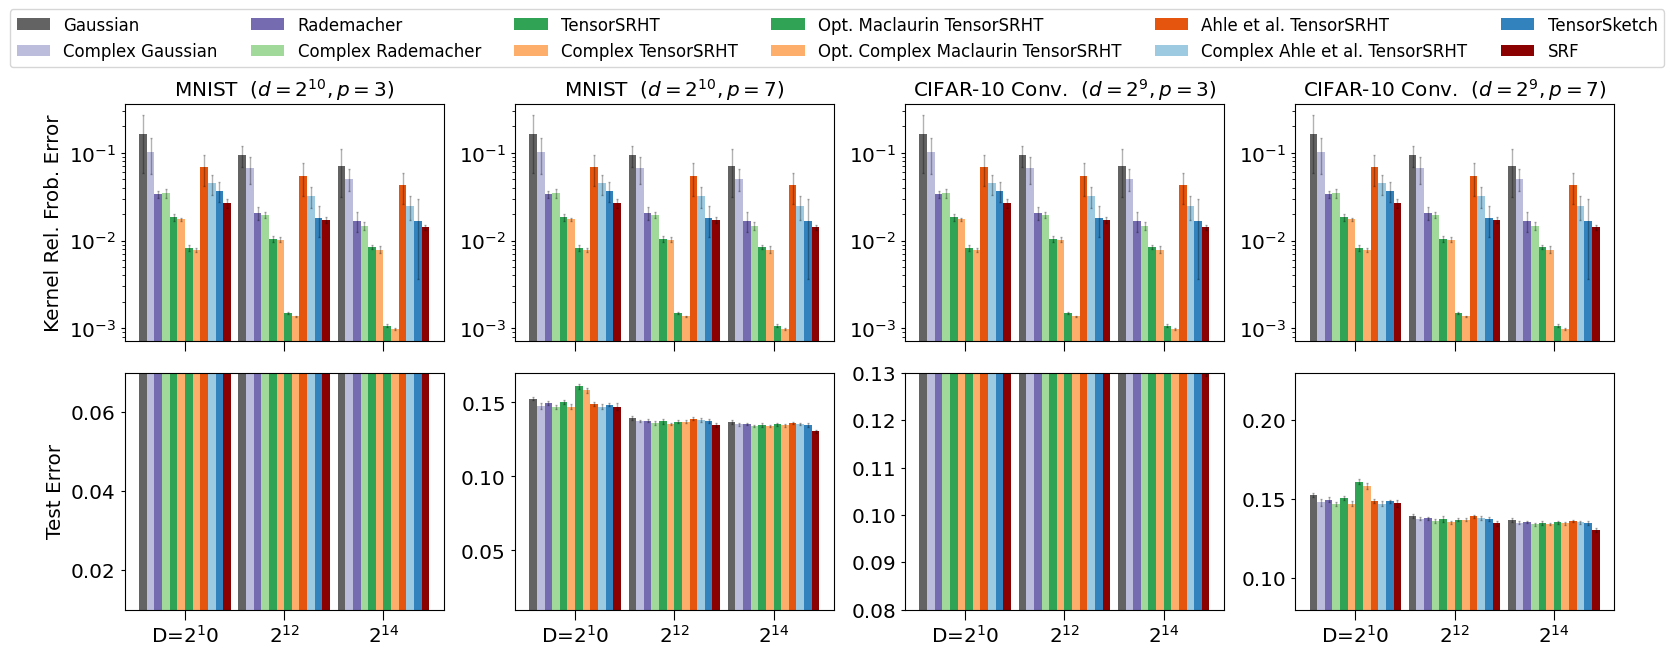

In [118]:
csv_files = [
    '../csv/poly3_approx_0mean/FashionMNIST_d1024_n70000.csv',
    '../csv/poly3_approx_0mean/FashionMNIST_d1024_n70000.csv',
    '../csv/poly3_approx_0mean/FashionMNIST_d1024_n70000.csv',
    '../csv/poly3_approx_0mean/FashionMNIST_d1024_n70000.csv'
]

Ds = [1024, 3072, 5120] # 15
D_labels = [r'D=$2^10$', r'$2^{12}$', r'$2^{14}$']

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 6))
plot_csv(axes[0,0], csv_files[0], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title='MNIST  $(d=2^{10}, p=3)$', x_axis=False, ylabel='Kernel Rel. Frob. Error')
plot_csv(axes[0,1], csv_files[1], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title='MNIST  $(d=2^{10}, p=7)$', x_axis=False)
plot_csv(axes[0,2], csv_files[2], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title='CIFAR-10 Conv.  $(d=2^9, p=3)$', x_axis=False)
plot_csv(axes[0,3], csv_files[3], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title='CIFAR-10 Conv.  $(d=2^9, p=7)$', x_axis=False)
plot_csv(axes[1,0], csv_files[0], configs, Ds, D_labels, error_field='test_error', y_lim=(0.01, 0.07), title='', ylabel='Test Error')
plot_csv(axes[1,1], csv_files[1], configs, Ds, D_labels, error_field='test_error', y_lim=(0.01, 0.17), title='')
plot_csv(axes[1,2], csv_files[2], configs, Ds, D_labels, error_field='test_error', y_lim=(0.08, 0.13), title='')
plot_csv(axes[1,3], csv_files[3], configs, Ds, D_labels, error_field='test_error', y_lim=(0.08, 0.23), title='')

handles, labels = axes[0,0].get_legend_handles_labels()
#axes[0].legend()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=6, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

In [82]:
[2**i for i in range(10, 15, 2)]

[1024, 4096, 16384]

In [93]:
configs = [
    ('Rademacher (this work)', {'method': 'poly_sketch', 'proj': 'gaussian', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[2]}),
    ('TensorSRHT (this work)', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[6]}),
    #  ('Complex TensorSRHT (this work)', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[7]}),
    ('TensorSketch', {'method': 'poly_sketch', 'proj': 'countsketch_scatter', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[4]}),
    ('SRF', {'method': 'srf', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': 'darkred'}),
]

In [94]:
df = pd.read_csv('../csv/poly3_approx_0mean/FashionMNIST_d1024_n70000.csv')

Ds = [1024, 3072, 5120] # 15
D_labels = [r'D=$2^10$', r'$2^{12}$', r'$2^{14}$']
df = df[df['D'].isin(Ds)]
seeds = df['seed'].unique()

bar_positions = np.arange(len(Ds))
width = 1./(len(configs)+1)

error_field = 'k_rel_frob_error'

for j, (name, config) in enumerate(configs):
    
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
    df_sel = df_sel[(df_sel['comp'] == config['complex'])]
    df_sel = df_sel[(df_sel['ahle'] == config['ahle'])]
    # df_sel = df_sel[(df_sel['seed'] < 10)]
    
    dataset = df_sel['dataset'].iloc[0]
    
    df_sel = df_sel.groupby(['D'])

    error_means = df_sel[error_field].mean()
    error_stds = df_sel[error_field].std()
    error_max = df_sel[error_field].max()
    error_min = df_sel[error_field].min()
    error_median = df_sel[error_field].median()

    print(config)
    print(error_means)

{'method': 'poly_sketch', 'proj': 'gaussian', 'complex': True, 'ahle': False, 'comp_real': False, 'color': array([0.63137255, 0.85098039, 0.60784314, 1.        ])}
D
1024    0.505431
3072    0.494547
5120    0.510303
Name: k_rel_frob_error, dtype: float64
{'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': array([0.61960784, 0.79215686, 0.88235294, 1.        ])}
D
1024    0.621160
3072    0.506233
5120    0.353365
Name: k_rel_frob_error, dtype: float64
{'method': 'poly_sketch', 'proj': 'countsketch_scatter', 'complex': False, 'ahle': False, 'comp_real': False, 'color': array([0.99215686, 0.68235294, 0.41960784, 1.        ])}
D
1024    0.035338
3072    0.015413
5120    0.014594
Name: k_rel_frob_error, dtype: float64
{'method': 'srf', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': 'darkred'}
D
1024    0.026364
3072    0.016962
5120    0.014053
Name: k_rel_frob_error, dtype: float64
